# Sentiment Analysis Using Various Approaches

## Lexicon-based approach 
- Unsupervised learning
- Based on calculating sentiment scores of words in a document from lexicons.
- Each word's sentiment is determined, and the scores are combined to calculate the overall sentiment of the sentence. 
- A lexicon is a dictionary that contains a collection of words that is categorized as positive, negative, and neutral by experts. Their scores can change over time.
- Only those words listed in the lexicon will actually be scored.
- Disadvantages: words that are not in the lexicon will not be scored; some lexicons might be better suited for a specific use; it overlooks negation (lexicons only match words and not phrases, ie "not bad" is scored more negative instead of neutral)

In [60]:
import numpy as np 
import pandas as pd
import json
import time
import re

# Text cleaning
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# NLTK Bing Liu Lexicon 
import nltk
# nltk.download('opinion_lexicon')
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize 

# VADER 
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, confusion_matrix

# Supervised learning 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC

# Text Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib as plt

# Topic Modeling 
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation

## Loading a subset of reviews and meta data

In [2]:
n = 1 
total_rows = 0

def process_chunks(file, chunksize = 1000):

    # Setting as global variables
    global n, total_rows  
    
    chunks = pd.read_json(file, lines=True, chunksize = chunksize)
    dfs = []  
    n_chunks = 0

    for chunk in chunks:
        dfs.append(chunk)
        n_chunks += 1  # Count the number of chunks processed
        print(len(chunk), " rows added")
        n += 1 
        total_rows += len(chunk)
        if n_chunks >= 10:  # Process only the first 5 chunks
            break  
            
    print("Done")
    print("Total rows:", total_rows)
    return pd.concat(dfs, ignore_index=True)

In [3]:
reviews = "../data/Home_and_Kitchen.jsonl"
meta = "../data/meta_Home_and_Kitchen.jsonl"

start = time.process_time()

reviews_subset = process_chunks(reviews)

end = time.process_time()
elapsed_time = end - start
print('Created a subset of the reviews dataset')
print('Execution time:', elapsed_time, 'seconds')

print('--------------')
start = time.process_time()

meta_subset = process_chunks(meta)

end = time.process_time()
elapsed_time = end - start
print('Created a subset of the meta dataset')
print('Execution time:', elapsed_time, 'seconds')

1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
Done
Total rows: 10000
Created a subset of the reviews dataset
Execution time: 0.203125 seconds
--------------
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
Done
Total rows: 20000
Created a subset of the meta dataset
Execution time: 0.859375 seconds


## Text Cleaning - spaCy

In [4]:
import spacy 
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
print('Original stopwords count:', len(stop_words))

# Updating my stopwords list 
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Include/ exclude certain words
include_stopwords = {'would', 'I'}
exclude_stopwords = {'i', 'well', 'off', 'very', 'not', 'few', 'much'}

stop_words |= include_stopwords
stop_words -= exclude_stopwords

# Remove adjectives from my stopwords using spaCy
exclude_adjectives = {word for word in stop_words if nlp(word)[0].pos_ == "ADJ"}
print(exclude_adjectives)

stop_words -= exclude_adjectives
print('Stopwords count:', len(stop_words))

Original stopwords count: 326
{'due', 'whole', 'own', 'serious', 'whereafter', 'least', 'such', 'same', 'last', 'other', 'several', 'various', 'empty', 'third', 'top', 'full', 'latter', 'many', 'former'}
Stopwords count: 301


In [5]:
def clean_data(doc):
    doc = doc.lower()
    doc = nlp(doc)
    # Lemmatize words 
    lemmas = [token.lemma_ for token in doc]
    # Removing non-alphabetic characters and stopwords
    tokens = [lemma for lemma in lemmas if lemma.isalpha() and lemma not in stop_words]
    cleaned_doc = " ".join(tokens)
    
    return cleaned_doc

cleaned_text = reviews_subset.copy()
cleaned_text['spacy_text'] = cleaned_text['text'].apply(clean_data)

In [21]:
i = 3
print(f'Title: {cleaned_text.loc[i,"title"]}\n')

print(f'Text: {cleaned_text.loc[i,"text"]}\n')

print(f'Text: {cleaned_text.loc[i,"spacy_text"]}\n')

Title: Best purchase ever!

Text: If you live at a higher elevation like me (5k Colorado) just know that after the buzzer beeps you might wanna leave the hard boiled eggs inside the steamed cooker for another minute or two if you want the egg cooked all the way through. I also add a bit more water than the fill line says, but again that’s bc of my elevation & it evaporates quickly.  It’s not any quicker than I used to make them, but it’s a lot less water. I’m disabled & have a TBI rn so the auto-cutoff was a no-brained for me. I bought the blue bc it was cheapest.  My service 🐶  🐶 love hard boiled eggs too so we are enjoying this new addition to our kitchen.  My only regret is that I did not buy it sooner & that Amazon never has the color I want for the cheapest price, but I can live with the bb blue.  We have used it 3x & so far it’s working okay. Oh- don’t place it under upper cabinets as it has a vent hole & it will vent & it will make the cabinets sweat.  Give it some room to breat

## Feature Engineering 

Create new features: word count, average word length, exclamation mark count.

In [7]:
# Word count
def word_count(text):
    words = text.split()
    return len(words)

# Average word length 
def avg_word_length(text):
    
    # Check for empty or white-space only string 
    if not text.strip():
        return 0
        
    words = text.split()
    if not words:  # Check if words list is empty
        return 0
        
    word_lengths = [len(word) for word in words]
    avg_word_length = sum(word_lengths)/len(words)
    
    return(avg_word_length) 

# Exclamation mark count 
def exclamation_count(text):
    doc = nlp(text)
    exclamations = []
    for token in doc: 
        if token.text == '!':
            exclamations.append(token.text)
    return len(exclamations)

In [14]:
cleaned_text['word_count'] = cleaned_text['text'].apply(word_count)
cleaned_text['avg_word_length'] = cleaned_text['text'].apply(avg_word_length)
cleaned_text['exclamation_count'] = cleaned_text['text'].apply(exclamation_count)
cleaned_text[['word_count', 'avg_word_length', 'exclamation_count']].head(3)

,word_count,avg_word_length,exclamation_count
0,28,4.678571,2
1,546,3.937729,0
2,319,4.047022,0


## Bing Liu Lexicon

The Bing Liu lexicon has a total of 6, 786 words with 2,005 classified as positive and 4,781 as negative. CLassification is binary (positive or negative).

In [15]:
print('Total number of words in opinion lexicon', len(opinion_lexicon.words()))
print('Examples of positive words:', opinion_lexicon.positive()[:10])
print('Examples of negative words:', opinion_lexicon.negative()[:10])

Total number of words in opinion lexicon 6789
Examples of positive words: ['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation']
Examples of negative words: ['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted']


In [16]:
pos_score = 1
neg_score = -1
word_dict = {}

# Adding the positive words to the dictionary
for word in opinion_lexicon.positive():
    word_dict[word] = pos_score 

# Adding the negative words to the dictionary 
for word in opinion_lexicon.negative():
    word_dict[word] = neg_score 

def bing_liu_score(text):
    sentiment_score = 0 
    bag_of_words = word_tokenize(text.lower())

    # Check if bag_of_words is empty
    if bag_of_words: 
        for word in bag_of_words: 
            if word in word_dict: 
                sentiment_score += word_dict[word]
        return sentiment_score / len(bag_of_words)
    else: 
        return 0

In [17]:
cleaned_text['Bing_Liu_score'] = cleaned_text['text'].apply(bing_liu_score)
cleaned_text['Bing_Liu_spaCy'] = cleaned_text['spacy_text'].apply(bing_liu_score)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,spacy_text,word_count,avg_word_length,exclamation_count,Bing_Liu_score,Bing_Liu_spaCy
0,1,Received Used & scratched item! Purchased new!,Livid. Once again received an obviously used ...,[],B007WQ9YNO,B09XWYG6X1,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2023-02-26 01:03:29.298,1,True,livid receive obviously use item food scratch ...,28,4.678571,2,-0.085714,-0.187500
1,5,Excellent for moving & storage & floods!,I purchased these for multiple reasons. The ma...,[],B09H2VJW6K,B0BXDLF8TW,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2022-12-26 08:30:10.846,0,True,purchase multiple reason main reason bc apt fl...,546,3.937729,0,-0.006568,-0.021459
2,2,Lid very loose- needs a gasket imo. Small base.,[[VIDEOID:c87e962bc893a948856b0f1b285ce6cc]] I...,[{'small_image_url': 'https://m.media-amazon.c...,B07RL297VR,B09G2PW8ZG,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2022-05-25 02:54:56.788,0,True,videoid want love bc previously buy matching t...,319,4.047022,0,-0.008287,-0.029851
3,5,Best purchase ever!,If you live at a higher elevation like me (5k ...,[{'small_image_url': 'https://m.media-amazon.c...,B09CQF4SWV,B08CSZDXZY,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2022-05-06 16:38:16.178,0,True,live high elevation like colorado know buzzer ...,417,3.812950,0,0.006316,-0.029586
4,5,Excellent for yarn!,I use these to store yarn. They easily hold 12...,[{'small_image_url': 'https://images-na.ssl-im...,B003U6A3EY,B0C6V27S6N,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2020-05-20 00:28:45.940,1,True,use store yarn easily hold ounce bernat pipsqu...,75,3.920000,0,0.035294,0.058824


## VADER Lexicon
Rule-based lexicon. 
9,000 features with scales of [-4] Extremely Negative to [4] Extremely Positive with [0] for Neutral or Neither. 

In [22]:
model = SentimentIntensityAnalyzer()

In [23]:
def vader_score(text):
    score = model.polarity_scores(text)
    compound_score = score['compound']
    return compound_score

In [24]:
cleaned_text['Vader_score'] = cleaned_text['text'].apply(vader_score)
cleaned_text['Vader_spaCy'] = cleaned_text['spacy_text'].apply(vader_score)

## Lexicon Sentiment Accuracy Scores 

In [ ]:
cleaned_text[['Bing_Liu_score', 'Bing_Liu_spaCy', 'Vader_score', 'Vader_spaCy']].sample(3)

In [25]:
# Calculate mean sentiment score for each rating category
mean_scores = cleaned_text.groupby('rating').agg({
    'Bing_Liu_score':'mean',
    'Bing_Liu_spaCy': 'mean',
    'Vader_score': 'mean',
    'Vader_spaCy': 'mean'
}).reset_index()

print(mean_scores)

   rating  Bing_Liu_score  Bing_Liu_spaCy  Vader_score  Vader_spaCy
0       1       -0.031370       -0.063742    -0.115005    -0.038082
1       2        0.003011        0.004356     0.100559     0.156293
2       3        0.031123        0.062282     0.350320     0.365816
3       4        0.066978        0.143764     0.663724     0.645764
4       5        0.129455        0.249447     0.720333     0.710219


## Supervised Learning Approach

In [26]:
cleaned_text.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'spacy_text',
       'word_count', 'avg_word_length', 'exclamation_count', 'Bing_Liu_score',
       'Bing_Liu_spaCy', 'Vader_score', 'Vader_spaCy'],
      dtype='object')

In [27]:
# Assigning a new target class 
cleaned_text['sentiment'] = 0

# Classify records with rating higher than a 3, positive (1)
cleaned_text.loc[cleaned_text['rating'] > 3, 'sentiment'] = 1

# Classify records with rating lower than a 3, negative (0)
cleaned_text.loc[cleaned_text['rating'] < 3, 'sentiment'] = 0

# Remove records with a rating of 3
cleaned_text = cleaned_text.loc[cleaned_text['rating'] != 3].reset_index(drop=True)

In [28]:
# Remove observations that are empty after the cleaning step
cleaned_text = cleaned_text[cleaned_text['spacy_text'].str.len() != 0]
print('Record count:', len(cleaned_text))

Record count: 9351


### Train-Test Split

In [29]:
# Creating train-test split with spacy cleaned text
X = cleaned_text[['spacy_text']]
y = cleaned_text['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)

In [30]:
print ('Size of Training Data ', X_train.shape[0])
print ('Size of Test Data ', X_test.shape[0])
print ('Distribution of classes in Training Data :')
print ('Positive Sentiment ', str(sum(y_train == 1)/ len(y_train) * 100.0))
print ('Negative Sentiment ', str(sum(y_train == 0)/ len(y_train) * 100.0))
print ('Distribution of classes in Testing Data :')
print ('Positive Sentiment ', str(sum(y_test == 1)/ len(y_test) * 100.0))
print ('Negative Sentiment ', str(sum(y_test == 0)/ len(y_test) * 100.0))


Size of Training Data  7480
Size of Test Data  1871
Distribution of classes in Training Data :
Positive Sentiment  91.81818181818183
Negative Sentiment  8.181818181818182
Distribution of classes in Testing Data :
Positive Sentiment  91.82255478353821
Negative Sentiment  8.177445216461784


### Model Testing
Use TF-IDF vectorizer to transform text into vector based on the frequency of word in the text. 

In [31]:
tfidf = TfidfVectorizer()
clf = MultinomialNB()

pipe = Pipeline([("tfidf", tfidf), ("clf", clf)])

param_grid = {
    'tfidf__ngram_range':[(1,1), (1,2), (1,3)],
    'tfidf__min_df':[1, 2, 5, 10, 20],
    'clf__fit_prior':[False, True]
}

In [32]:
rs = RandomizedSearchCV(estimator = pipe, param_distributions = param_grid, verbose = 2, n_jobs = -1)
rs.fit(X_train['spacy_text'], y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('clf', MultinomialNB())]),
                   n_jobs=-1,
                   param_distributions={'clf__fit_prior': [False, True],
                                        'tfidf__min_df': [1, 2, 5, 10, 20],
                                        'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (1, 3)]},
                   verbose=2)

In [33]:
y_pred = rs.predict(X_test['spacy_text'])

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9214323890967397
ROC-AUC Score: 0.5672388474210017
[[  22  131]
 [  16 1702]]


In [34]:
# Finding the best parameters 
print(rs.best_params_)
print(rs.best_score_)

{'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 20, 'clf__fit_prior': True}
0.9251336898395722


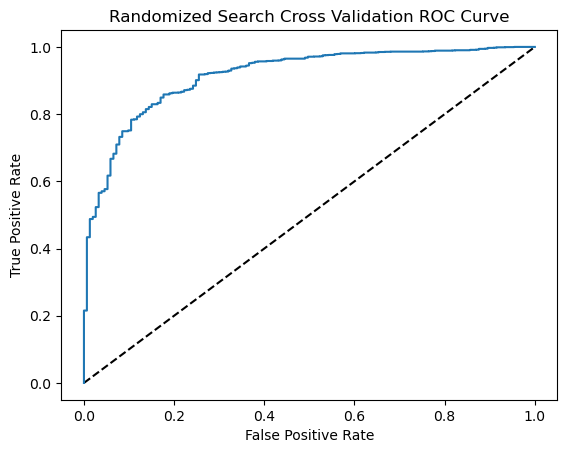

0.91472262168352


In [35]:
sentiment_prob = rs.predict_proba(X_test['spacy_text'])
positive_class_prob = sentiment_prob[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, positive_class_prob, pos_label = 1)
plt.plot([0, 1], [0, 1],
'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Randomized Search Cross Validation ROC Curve')
plt.show()

print(roc_auc_score(y_test, positive_class_prob))

In [36]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range = (1,2))

X_train_tf = tfidf.fit_transform(X_train['spacy_text'])
X_test_tf = tfidf.transform(X_test['spacy_text'])

linear = LinearSVC(random_state = 42, tol = 1e-5)
linear.fit(X_train_tf, y_train)

LinearSVC(random_state=42, tol=1e-05)

In [38]:
y_pred = linear.predict(X_test_tf)
print ('Accuracy Score:', accuracy_score(y_test, y_pred))
print ('ROC-AUC Score:', roc_auc_score(y_test, y_pred))

Accuracy Score: 0.9465526456440406
ROC-AUC Score: 0.7267874941983001


### Sample Application

In [40]:
sample_reviews = cleaned_text.sample(5)
sample_reviews_tf = tfidf.transform(sample_reviews['spacy_text'])
sentiment_predictions = linear.predict(sample_reviews_tf)
sentiment_predictions = pd.DataFrame(data = sentiment_predictions,
                                     index=sample_reviews.index,
                                     columns=['sentiment_prediction'])
sample_reviews = pd.concat([sample_reviews, sentiment_predictions], axis=1)
print ('Some sample reviews with their sentiment - ')
sample_reviews[['text', 'spacy_text','rating', 'sentiment_prediction']]


Some sample reviews with their sentiment - 


,text,spacy_text,rating,sentiment_prediction
2979,"was delivered yesterday, used it today. It is ...",deliver yesterday use today amazing clean new ...,5,1
8771,Good Product,good product,5,1
6604,Pain in the ass to use plastic garbage and eve...,pain ass use plastic garbage bad taste insipid,1,0
6673,"Colors, softness are nice, but this is not a r...",color softness nice not rug last basically bac...,2,1
3028,Absolutely as promised! I am a dragonfly addi...,absolutely promise dragonfly addict shower cur...,5,1


## Topic Modeling
Singular Value Decomposition (SVD, aka Latent Semantic Indexing)

Non-Negative Matrix Factorization (NMF) yields two matrices: W and H. Matrix W (document-topic matrix) shows the distribution of the topics across the documents. Matrix H (term-topic matrix) captures the term significance across the topics. 
- Easier to interpret since elements in matrices is positive
- Higher score means stronger relevance 

### SVD

In [84]:
svd_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components = 10))
])

svd_pipe.fit(cleaned_text['spacy_text'])

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('svd', TruncatedSVD(n_components=10))])

In [91]:
vocab = svd_pipe.named_steps['tfidf'].get_feature_names_out()
components = svd_pipe.named_steps['svd'].components_

topic_num = 0

pd.DataFrame({
    'word': vocab,
    'weight': components[topic_num]
}).sort_values('weight', ascending = False).head(10)

,word,weight
6119,product,0.566727
3343,good,0.542090
5240,not,0.193699
3425,great,0.184518
8687,very,0.141495
4581,love,0.137910
8600,use,0.121252
4550,look,0.119715
8860,well,0.118969
5188,nice,0.118777


In [94]:
# Function that displays the top 10 words in the topics
def display_topics(model, features, no_top_words = 10):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # invert sort order 
        print(f"\nTopic {topic:02d}") ## Topic number 
        for i in range(no_top_words): 
            print(f"    {features[largest[i]]} ({word_vector[largest[i]] * 100.0 / total:.2f})")
    

In [95]:
display_topics(svd_pipe.named_steps['svd'], vocab)


Topic 00
    product (3.89)
    good (3.72)
    not (1.33)
    great (1.27)
    very (0.97)
    love (0.95)
    use (0.83)
    look (0.82)
    well (0.82)
    nice (0.82)

Topic 01
    product (-3.04)
    good (-2.19)
    wilton (-0.00)
    communication (-0.00)
    nespressos (-0.00)
    unsatisfied (-0.00)
    ip (-0.00)
    legging (-0.00)
    goer (-0.00)
    vocal (-0.00)

Topic 02
    love (-12.48)
    great (-5.31)
    beautiful (-1.06)
    gift (-0.92)
    product (-0.79)
    color (-0.65)
    perfect (-0.61)
    price (-0.58)
    absolutely (-0.48)
    buy (-0.43)

Topic 03
    great (-22.15)
    work (-6.57)
    price (-2.93)
    look (-2.26)
    product (-2.18)
    quality (-1.42)
    well (-1.15)
    value (-1.12)
    recommend (-0.66)
    nice (-0.43)

Topic 04
    nice (-9.88)
    very (-6.31)
    quality (-4.49)
    look (-3.88)
    soft (-2.43)
    good (-2.21)
    color (-2.20)
    beautiful (-1.78)
    cute (-1.41)
    price (-1.33)

Topic 05
    very (-17.15)
    wo

In [74]:
vect_lsa = TfidfVectorizer()
lsa = TruncatedSVD(n_components = 25)
lsa_pipe = Pipeline([
    ('vect', vect_lsa),
    ('topic', lsa)
])

lsa_pipe.fit(cleaned_text['spacy_text'])

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('topic', TruncatedSVD(n_components=25))])

In [ ]:
nmf = NMF(n_components = 15, random_state = 42)
W_text_matrix = mf.fit_tranform()

In [65]:
reviews_lsa = lsa_pipe.transform(cleaned_text['spacy_text'])

In [66]:
reviews_lsa

array([[ 0.05265771, -0.08323176, -0.05644967, ...,  0.00364687,
         0.017497  , -0.03323392],
       [ 0.1216464 , -0.19238105, -0.09609799, ..., -0.00735126,
         0.05602998,  0.05089497],
       [ 0.12214999, -0.14257336, -0.02373624, ..., -0.11246675,
        -0.02883718,  0.08281011],
       ...,
       [ 0.1732488 , -0.09453508, -0.0655192 , ...,  0.01387944,
        -0.00268443, -0.01719534],
       [ 0.12549746, -0.1934782 , -0.04579882, ...,  0.20150995,
        -0.04665784, -0.04753027],
       [ 0.05905688, -0.09724546,  0.16963775, ..., -0.06048722,
        -0.11774972,  0.03549256]])

## EDA

### How many reviews are there per year?

<Axes: xlabel='year'>

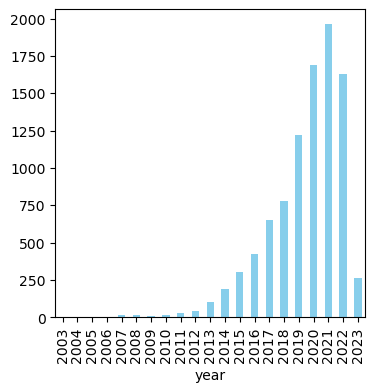

In [55]:
## Displays graphs directly within the notebook
%matplotlib inline 

# Create a year column from the timestamp column 
cleaned_text['year'] = cleaned_text['timestamp'].dt.year

# Group by year and count reviews 
reviews_per_year = cleaned_text.groupby('year').size()

# Plot 
reviews_per_year.plot(kind = 'bar', figsize = (4,4), color = 'skyblue')
